### AI Developer Productivty

#### Tujuan
Membuat Machine Learning Model untuk memprediksi task success/tugas yang diselesaikan developer dengan AI

### 1. Memuat dan periksa data

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [154]:
df = pd.read_csv("./ai_dev_productivity.csv")

In [155]:
df

,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success
0,5.99,600,1,5.8,2,1,0.71,5.4,1
1,4.72,568,2,6.9,5,3,1.75,4.7,1
2,6.30,560,1,8.9,2,0,2.27,2.2,1
3,8.05,600,7,6.3,9,5,1.40,5.9,0
4,4.53,421,6,6.9,4,0,1.26,6.3,1
...,...,...,...,...,...,...,...,...,...
495,6.08,594,1,5.3,3,0,0.91,6.8,1
496,2.93,382,2,6.7,3,2,1.38,5.9,0
497,4.62,494,4,7.5,2,0,0.41,4.5,1
498,3.25,296,6,6.9,1,0,1.52,6.3,0


In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   hours_coding      500 non-null    float64
 1   coffee_intake_mg  500 non-null    int64  
 2   distractions      500 non-null    int64  
 3   sleep_hours       500 non-null    float64
 4   commits           500 non-null    int64  
 5   bugs_reported     500 non-null    int64  
 6   ai_usage_hours    500 non-null    float64
 7   cognitive_load    500 non-null    float64
 8   task_success      500 non-null    int64  
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


In [157]:
df.duplicated().sum()

np.int64(0)

In [158]:
df.describe()

,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000
mean,5.015600,463.192000,2.976000,6.975800,4.60800,0.858000,1.510920,4.498200,0.606000
std,1.947253,142.334991,1.678409,1.455965,2.70499,1.102846,1.085557,1.868861,0.489124
min,0.000000,6.000000,0.000000,3.000000,0.00000,0.000000,0.000000,1.000000,0.000000
25%,3.600000,369.500000,2.000000,6.100000,3.00000,0.000000,0.697500,3.175000,0.000000
50%,5.030000,500.500000,3.000000,6.950000,5.00000,0.000000,1.260000,4.400000,1.000000
75%,6.275000,600.000000,4.000000,7.900000,6.00000,2.000000,2.070000,5.800000,1.000000
max,12.000000,600.000000,8.000000,10.000000,13.00000,5.000000,6.360000,10.000000,1.000000


### 2. Exploratory Data Analysis (EDA)

Melihat distribusi data 

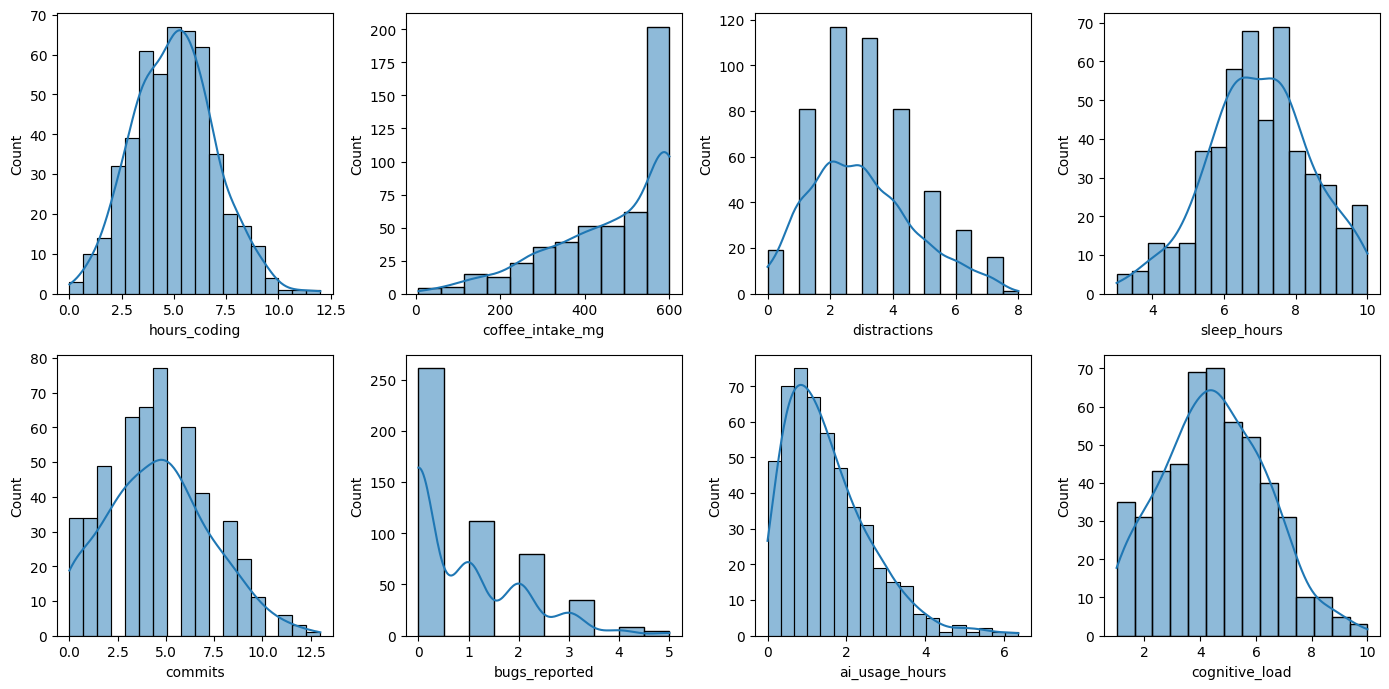

In [159]:
fig, axes = plt.subplots(2, 4, figsize=(14,7))
ax = axes.flatten()
cols = df.drop('task_success', axis=1).columns

for i, col in enumerate(cols):
    sns.histplot(data=df, x=col, kde=True, ax=ax[i])

plt.tight_layout()
plt.show()

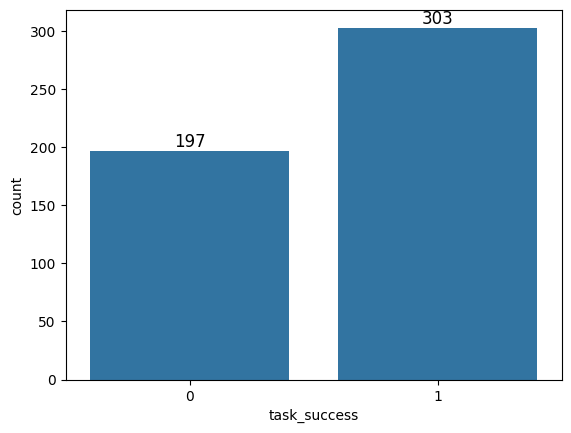

In [160]:
ax = sns.countplot(data=df, x='task_success')
plt.bar_label(ax.containers[0], fontsize=12)
plt.show()

Mencari hubungan tiap fitur yang berkorelasi dengan task success

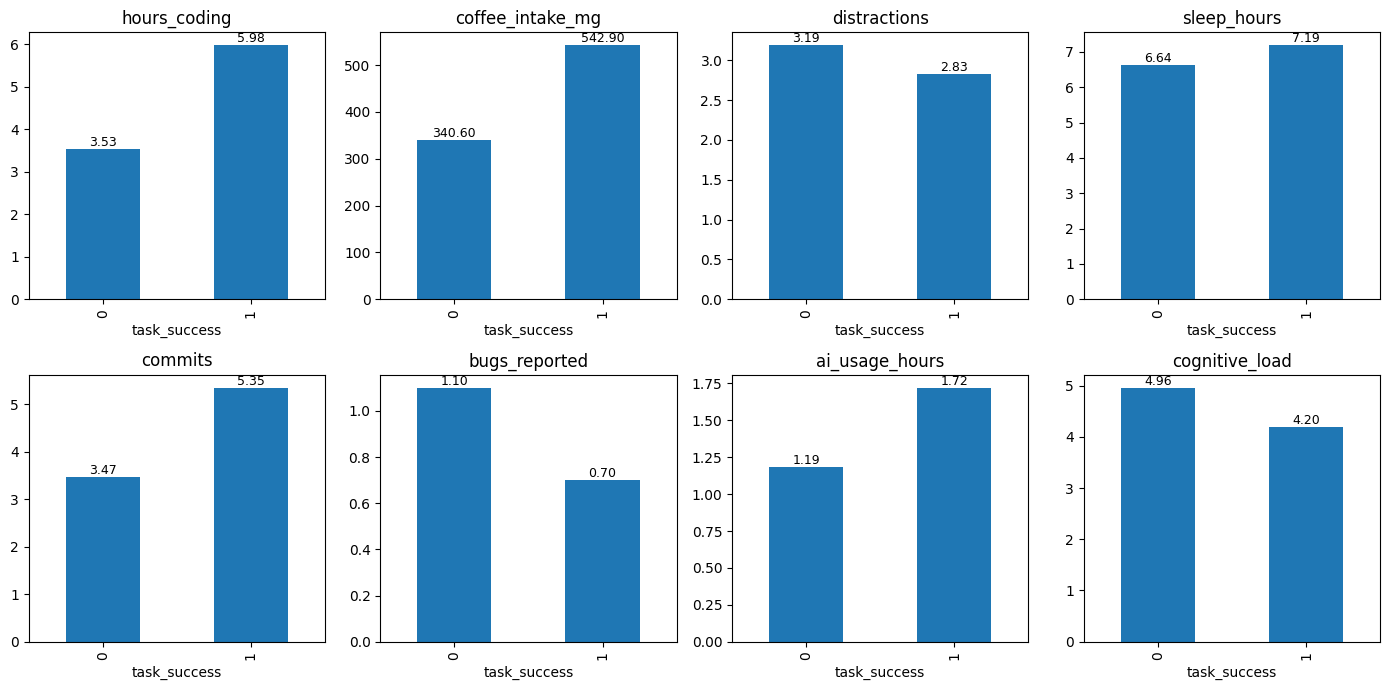

In [161]:
fig, axes = plt.subplots(2, 4, figsize=(14,7))
ax = axes.flatten()
cols = df.drop('task_success', axis=1).columns

for i, col in enumerate(cols):
    df.groupby('task_success')[col].mean().plot(kind='bar', ax=ax[i])

    for p in ax[i].patches:
        height = p.get_height()
        ax[i].text(p.get_x() + p.get_width() / 2., height,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=9)

    ax[i].set_title(col)

plt.tight_layout()
plt.show()

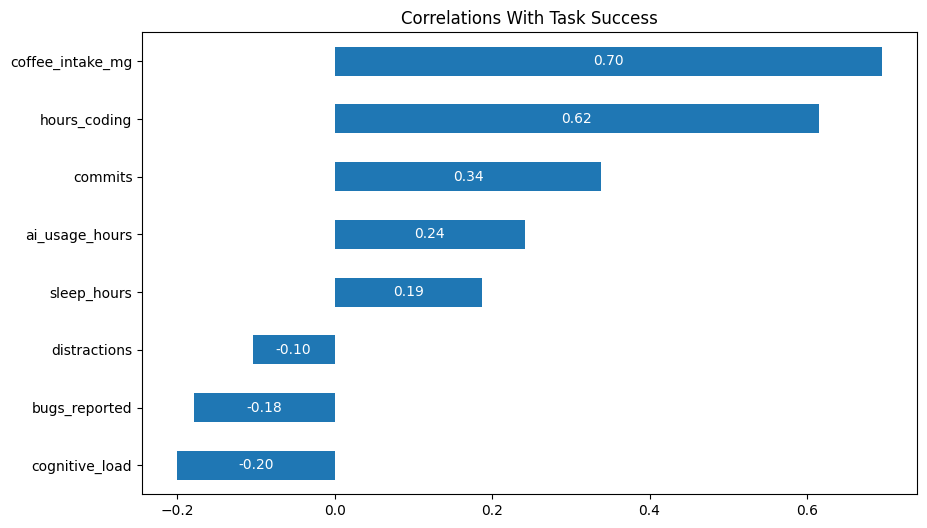

In [162]:
ax = df.corr().task_success[:-1].sort_values().plot(kind='barh', title='Correlations With Task Success', figsize=(10,6))
plt.bar_label(ax.containers[0], fmt='%.2f', label_type='center', color='white')
plt.show()

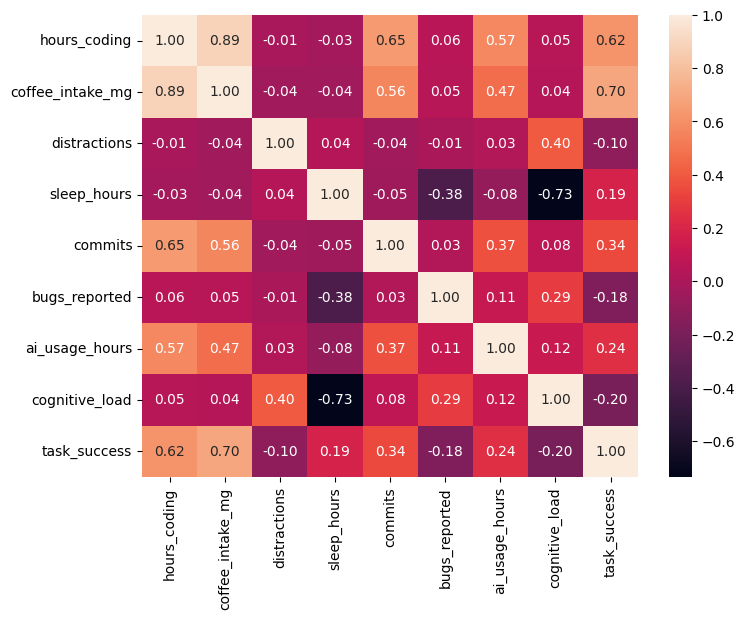

In [163]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, fmt='.2f');

### 3. Preprocessing

In [164]:
from sklearn.metrics import confusion_matrix, classification_report

def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [165]:
X = df.drop('task_success', axis=1)
y = df.task_success

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify = y, random_state=42)

In [166]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4. Melatih Model

Pemilihan model disini berdasarkan:
Datasetnya cukup kecil. Oleh karena itu, algoritma seperti Random Forest dan XGBoost memberikan akurasi 100%, sehingga tidak ada ruang untuk perbaikan. Overfitting

#### Regresi Logistik

In [167]:
from sklearn.linear_model import LogisticRegression

model1 = LogisticRegression(class_weight='balanced')
model1.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced')

In [168]:
eval_metric(model1, X_train_scaled, y_train, X_test_scaled, y_test)

Test_Set
[[36  3]
 [ 9 52]]
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        39
           1       0.95      0.85      0.90        61

    accuracy                           0.88       100
   macro avg       0.87      0.89      0.88       100
weighted avg       0.89      0.88      0.88       100


Train_Set
[[135  23]
 [ 29 213]]
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       158
           1       0.90      0.88      0.89       242

    accuracy                           0.87       400
   macro avg       0.86      0.87      0.86       400
weighted avg       0.87      0.87      0.87       400



### 5. Visualisasi 

In [169]:
coefficients = model1.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients,
    'Absolute_Coeff': np.abs(coefficients)
}).sort_values('Absolute_Coeff', ascending=False)

print(feature_importance)

            Feature  Coefficient  Absolute_Coeff
1  coffee_intake_mg     2.794625        2.794625
5     bugs_reported    -0.697218        0.697218
3       sleep_hours     0.604674        0.604674
0      hours_coding     0.546273        0.546273
7    cognitive_load    -0.388072        0.388072
2      distractions    -0.347617        0.347617
6    ai_usage_hours    -0.309153        0.309153
4           commits    -0.259365        0.259365


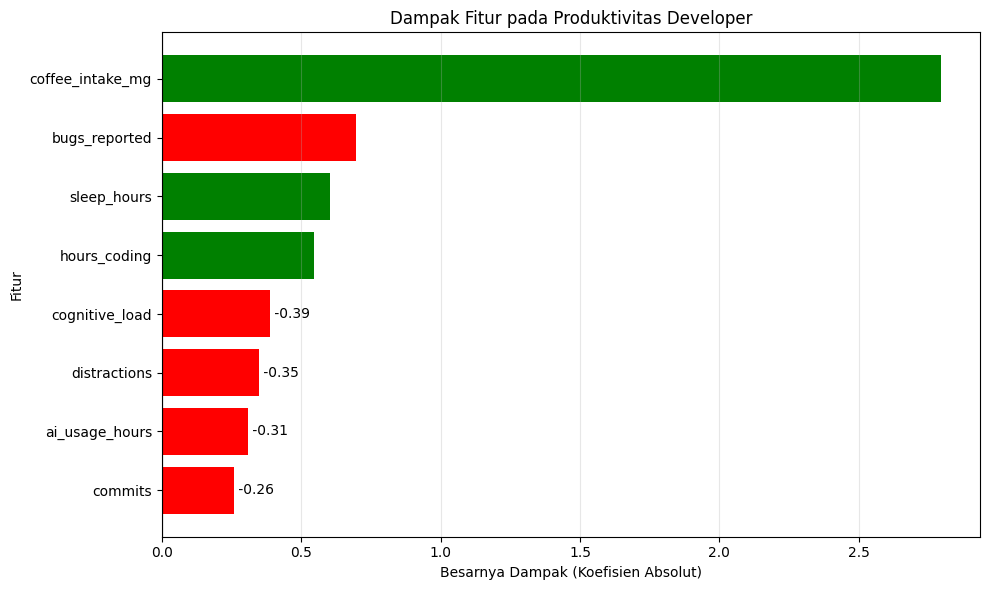

In [179]:
sorted_features = feature_importance.sort_values('Absolute_Coeff', ascending=True)

plt.figure(figsize=(10,6))
bars = plt.barh(sorted_features['Feature'], sorted_features['Absolute_Coeff'], 
               color=['red' if x < 0 else 'green' for x in sorted_features['Coefficient']])
plt.axvline(x=0, color='black', linestyle='-')
plt.title('Dampak Fitur pada Produktivitas Developer')
plt.xlabel('Besarnya Dampak (Koefisien Absolut)')
plt.ylabel('Fitur')
plt.grid(axis='x', alpha=0.3)

for bar, coef in zip(bars, sorted_features['Coefficient']):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f' {coef:.2f}', 
            va='center', 
            color='white' if width > 0.5 else 'black')

plt.tight_layout()

### 6. Implementasi Prediksi

In [171]:
y_pred = model1.predict(X_test_scaled) 
y_proba = model1.predict_proba(X_test_scaled)[:, 1]

Test memprediksi data

In [172]:
new_data = pd.DataFrame([[6.08,594,1,5.3,3,0,0.91,6.8]], 
                       columns=X_train.columns)

new_data_scaled = scaler.transform(new_data)
prediction = model1.predict(new_data_scaled)
probability = model1.predict_proba(new_data_scaled)[:, 1]

print(f"Prediksi: {'Produktif' if prediction[0] == 1 else 'Tidak Produktif'}")
print(f"Probabilitas Produktif: {probability[0]:.2%}")

Prediksi: Produktif
Probabilitas Produktif: 96.12%


### 7. Export model

In [173]:
import pickle
with open('logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(model1, file)

In [174]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Save the scaler to a file
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)